In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy.random as npr
import jax.numpy as jnp
from jax import jit, grad
from jax import vmap
from scipy.optimize import curve_fit
from jax.experimental.ode import odeint
from jax.scipy.optimize import minimize
from scipy.optimize import minimize as _minimize_
from scipy.integrate import odeint as _odeint_

# Toy Example

From http://implicit-layers-tutorial.org/neural_odes/

### Toy dataset

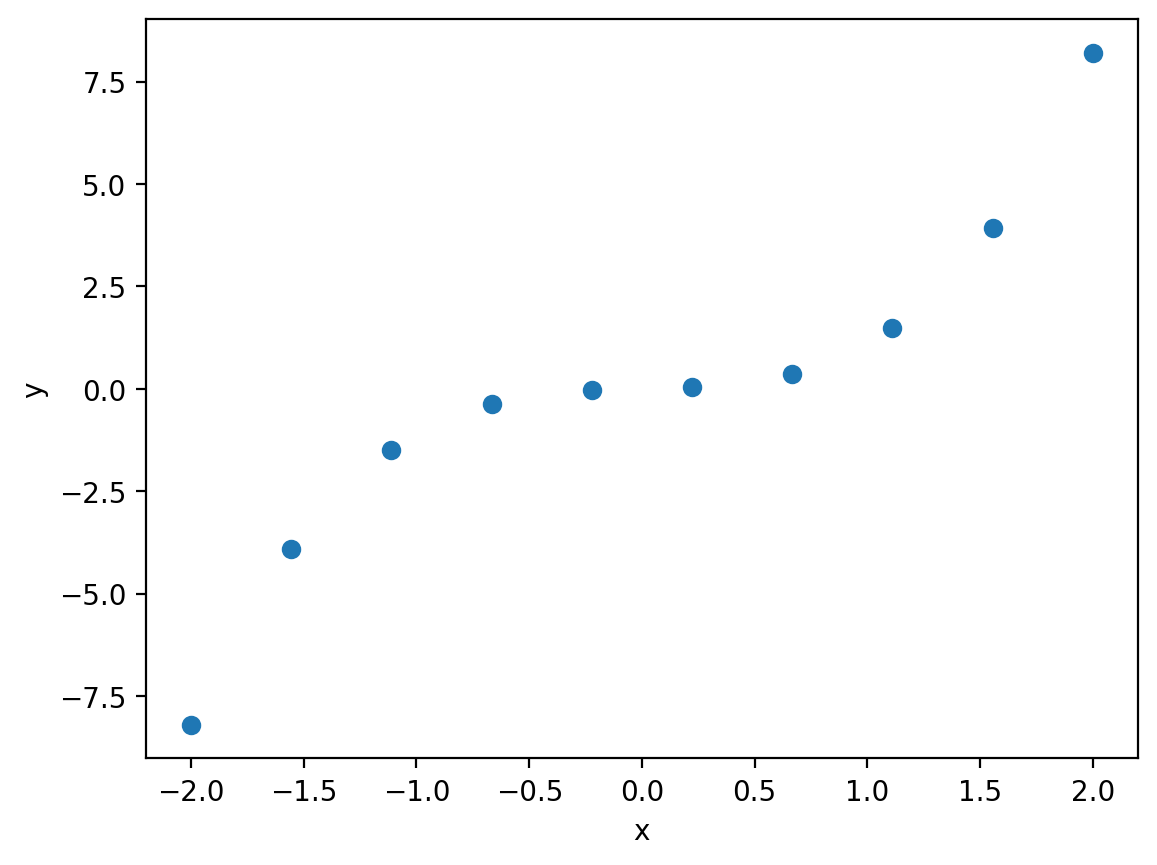

In [2]:
# Toy 1D dataset.
x = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
y = x**3 + 0.1 * x

plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y');

### MLP

In [3]:
def mlp(params, x):
    # A multi-layer perceptron, i.e. a fully-connected neural network.
    for w, b in params:
        y = jnp.dot(x, w) + b  # Linear transform
        x = jnp.tanh(y)        # Nonlinearity
    return y

In [4]:
param_scale = 1.0

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [
        (scale * rng.randn(m, n), scale * rng.randn(n))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])
    ]

### ResNet

In [5]:
def resnet(params, x, depth):
    for i in range(depth):
        y = mlp(params, x) + x
    return y

In [6]:
resnet_depth = 3
def resnet_loss(params, x, y):
    yhat = resnet(params, x, resnet_depth)
    return jnp.mean((yhat - y)**2)

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# A simple gradient-descent optimizer.
@jit
def resnet_update(params, x, y):
    grads = grad(resnet_loss)(params, x, y)
    return [
        (w - η * dw, b - η * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

In [7]:
# Hyperparameters.
layer_sizes = [1, 20, 1]
η = 0.01
train_iters = 1000

In [8]:
# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
    resnet_params = resnet_update(resnet_params, x, y)

### ODENet

In [9]:
def nn_dynamics(y, t, params):
    y_and_t = jnp.hstack([y, jnp.array(t)])
    return mlp(params, y_and_t)

In [10]:
def odenet(params, y0, t=jnp.array([0.0, 1.0])):
    _, y1 = odeint(nn_dynamics, y0, t, params)
    return y1

odenet = vmap(odenet, in_axes=(None, 0))

In [11]:
def odenet_loss(params, x, y):
    yhat = odenet(params, x)
    return jnp.mean((yhat - y)**2)

In [12]:
@jit
def odenet_update(params, x, y):
    grads = grad(odenet_loss)(params, x, y)
    return [
        (w - η * dw, b - η * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

In [13]:
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

# Initialize 
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

In [14]:
# train
for i in range(train_iters):
    odenet_params = odenet_update(odenet_params, x, y)

In [16]:
# train
for i in range(train_iters):
    odenet_params = odenet_update(odenet_params, x, y)

### Compare ResNet and ODENet

resent =  0.10412481 odenet =  0.0023549802


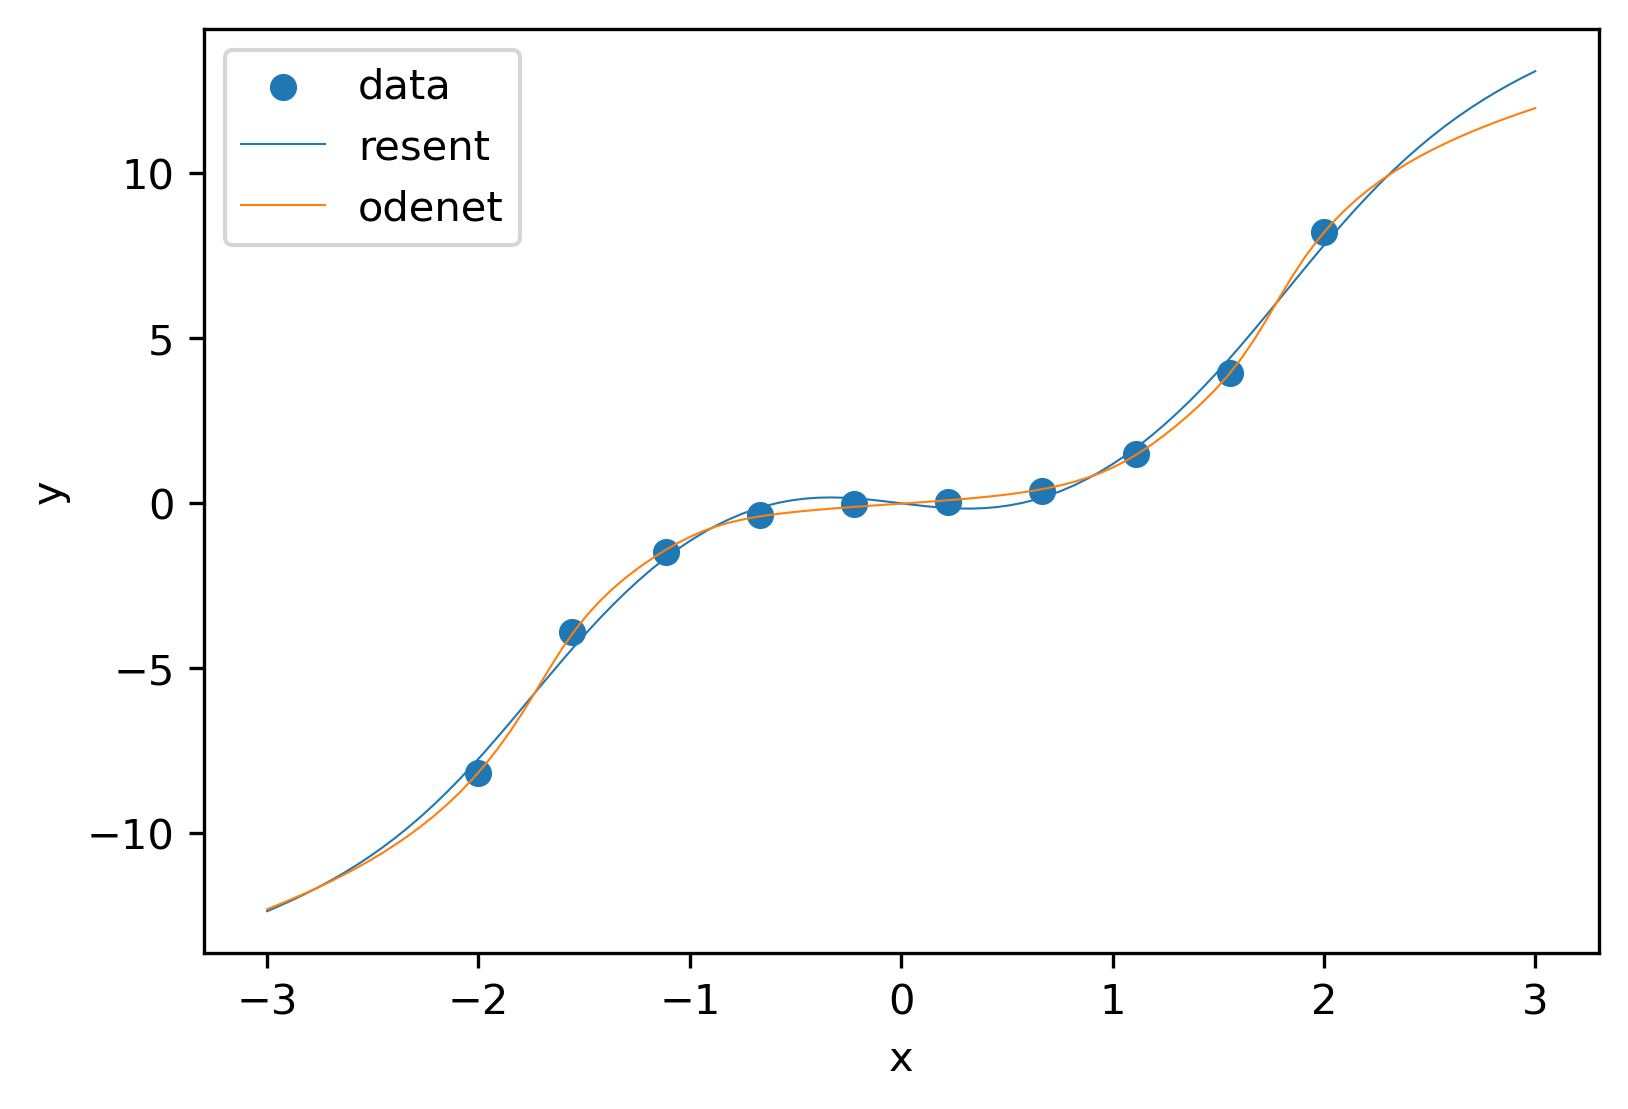

In [17]:
print(
    'resent = ', resnet_loss(resnet_params, x, y),
    'odenet = ', odenet_loss(odenet_params, x, y)
)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(x, y, lw=0.5, label='data')
fine_x = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_x, resnet(resnet_params, fine_x, resnet_depth), lw=0.5, label='resent')
ax.plot(fine_x, odenet(odenet_params, fine_x), lw=0.5, label='odenet')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend();

# Logistic equation

In [18]:
def logistic(t, y0, r, K):
    return K / (1 - (1 - K/y0) * jnp.exp(-r * t))

def logistic_loss(params, t, y):
    yhat = logistic(t, *params)
    return jnp.mean((yhat - y)**2)

In [19]:
K = 1.2
r = 0.5
y0 = 0.2
reps = 5
t = jnp.linspace(0, 24, 24*2)
t = jnp.array([t]*reps).squeeze()

In [20]:
y = logistic(t, y0, r, K) + npr.normal(0, 0.02, size=t.shape)
y = y.squeeze()

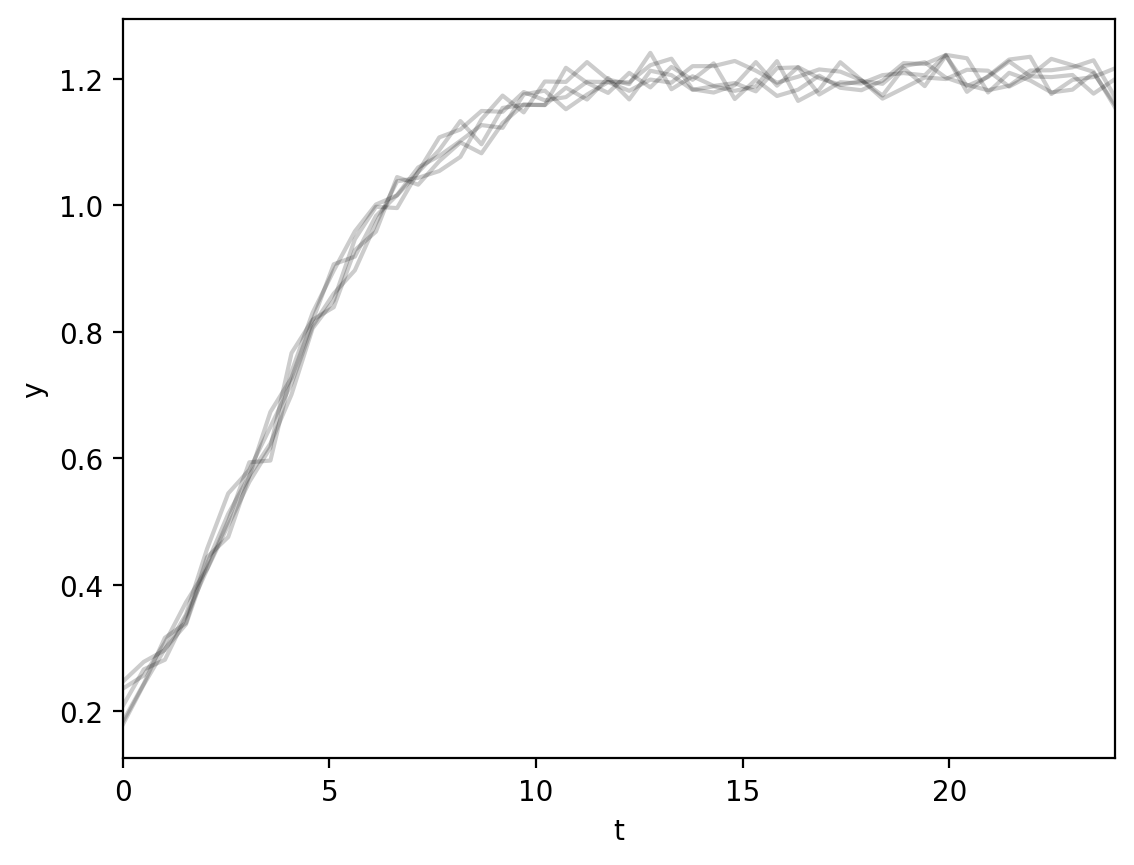

In [21]:
plt.plot(t.T, y.T, '-k', alpha=1/reps)
plt.xlabel('t')
plt.ylabel('y')
plt.xlim(0, 24);

### Curve fitting the equation

In [22]:
params_guess = jnp.array([y.min(), 1, y.max()])
params, pcov = curve_fit(logistic, t.ravel(), y.ravel(), params_guess)

0.2 0.5 1.2 | 0.00040311948
0.20128386981070637 0.4991952381803526 1.2042213722496522 | 0.0003895881


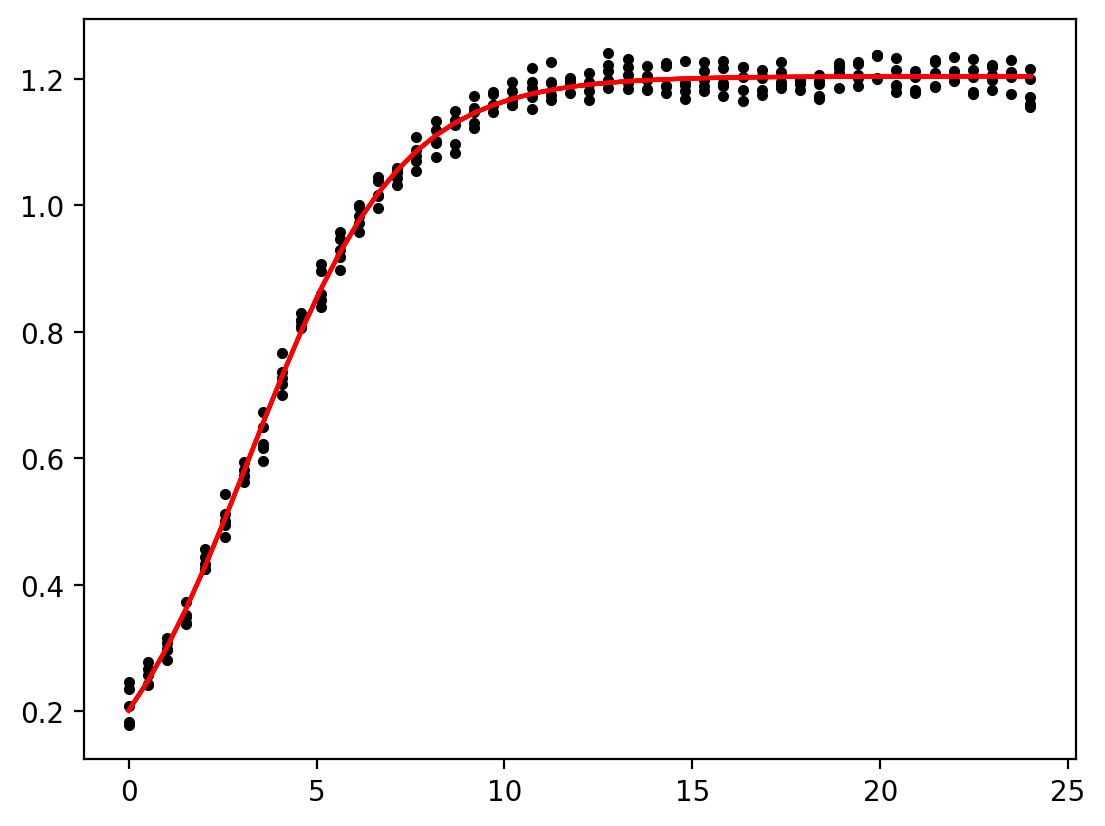

In [23]:
print(y0, r, K, '|', logistic_loss((y0, r, K), t, y))
print(*params, '|', logistic_loss(params, t, y))

plt.plot(t, y, '.k')
plt.plot(t.T, logistic(t, *params).T, '-r');

### Curve fitting the logistic ODE - JAX

In [24]:
def logistic_ode(y, t, r, K):
    return r * y * (1 - y/K)

def logistic_odeint(t, y0, r, K):
    return odeint(logistic_ode, y0, t, r, K)

# plt.plot(t[0], logistic_odeint(t[0], y0, r, K));

In [25]:
# logistic_odeint = vmap(logistic_odeint, in_axes=(0, None, None, None))

# plt.plot(t.T, logistic_odeint(t, y0, r, K).T);

In [26]:
def logistic_odeint_loss(params, t, y):
    yhat = logistic_odeint(t, *params).reshape((1, -1))
    return jnp.mean((yhat - y)**2)

print(logistic_odeint_loss([y0, r, K], t[0], y))

0.0004031221


In [27]:
res = minimize(logistic_odeint_loss, params_guess, args=(t[0], y), method='BFGS')
print(res.success)

False


In [28]:
if not res.success:
    res = minimize(logistic_odeint_loss, res.x, args=(t[0], y), method='BFGS')
    print(res.success)

True


0.2 0.5 1.2 | 0.0004031221
[0.20128083 0.49919215 1.2042261 ] | 0.00038958865


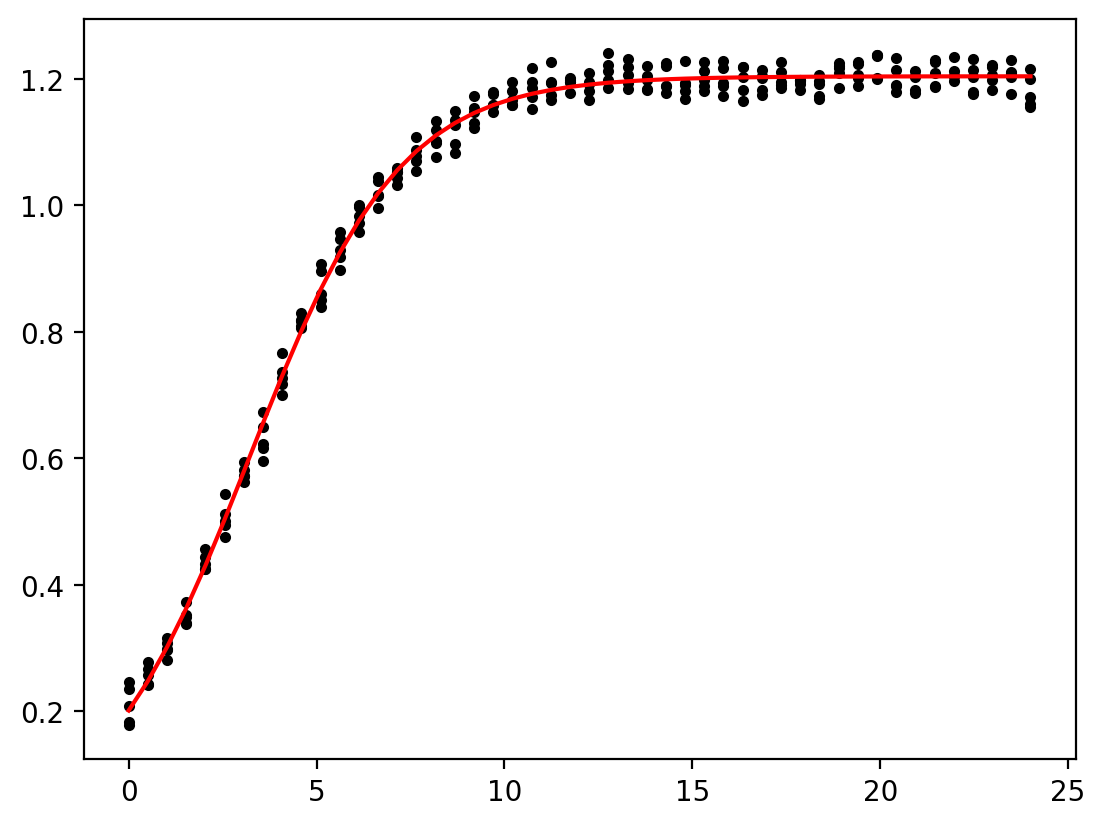

In [29]:
print(y0, r, K, '|', logistic_odeint_loss([y0, r, K], t[0], y))
print(res.x, '|', logistic_odeint_loss(res.x, t[0], y))

plt.plot(t, y, '.k')
plt.plot(t[0], logistic_odeint(t[0], *res.x), '-r');

### Fitting ODEnet

In [30]:
def mlp_ode(y, t, params):
    y_and_t = jnp.hstack([y, t])
    return mlp(params, y_and_t)

def odenet_odeint(t, params):
    return odeint(mlp_ode, y0, t, params)

# odenet_odeint = vmap(odenet_odeint, in_axes=(0, None))

In [31]:
def odenet_loss(params, t, y):
    yhat = odenet_odeint(t, params).reshape((1, -1))
    return jnp.mean((yhat - y)**2)

In [32]:
@jit
def odenet_update(params, t, y):
    grads = grad(odenet_loss)(params, t, y)
    return [
        (w - η * dw, b - η * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

In [33]:
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 6, 6, 1] # t,y(t) -> ... -> y(t+dt)
# Initialize 
odenet_params = init_random_params(param_scale, odenet_layer_sizes)
print(sum(__.size for _ in odenet_params for __ in _))

67


In [34]:
# train
η = 0.01
train_iters = 1000000

for i in range(train_iters):
    odenet_params = odenet_update(odenet_params, t[0], y)
    if i % 5000 == 0:
        print(i, odenet_loss(odenet_params, t[0], y))

0 131.81291
5000 0.0044554514
10000 0.0023229162
15000 0.0017886197
20000 0.0014564791
25000 0.001261144
30000 0.0011124271
35000 0.0009967838
40000 0.0009056021
45000 0.0008329434
50000 0.0007745297
55000 0.00072706793
60000 0.000688042
65000 0.00065569556
70000 0.0006284404
75000 0.0006052384
80000 0.0005898033
85000 0.0005779843
90000 0.000567442
95000 0.00055784016
100000 0.0005489524
105000 0.0005406805
110000 0.00053310697
115000 0.00052631256
120000 0.0005199418
125000 0.0005138974
130000 0.0005082313
135000 0.00050291576
140000 0.000497857
145000 0.00049304706
150000 0.00048859866
155000 0.0004845434
160000 0.00048070843
165000 0.000477074
170000 0.0004735961
175000 0.000470258
180000 0.0004670442
185000 0.00046400787
190000 0.00046108747
195000 0.00045828344
200000 0.0004555908
205000 0.00045304032
210000 0.00045063236
215000 0.00044832114
220000 0.00044608646
225000 0.00044407006
230000 0.00044219842
235000 0.00044043234
240000 0.00043872616
245000 0.00043710327
250000 0.0004

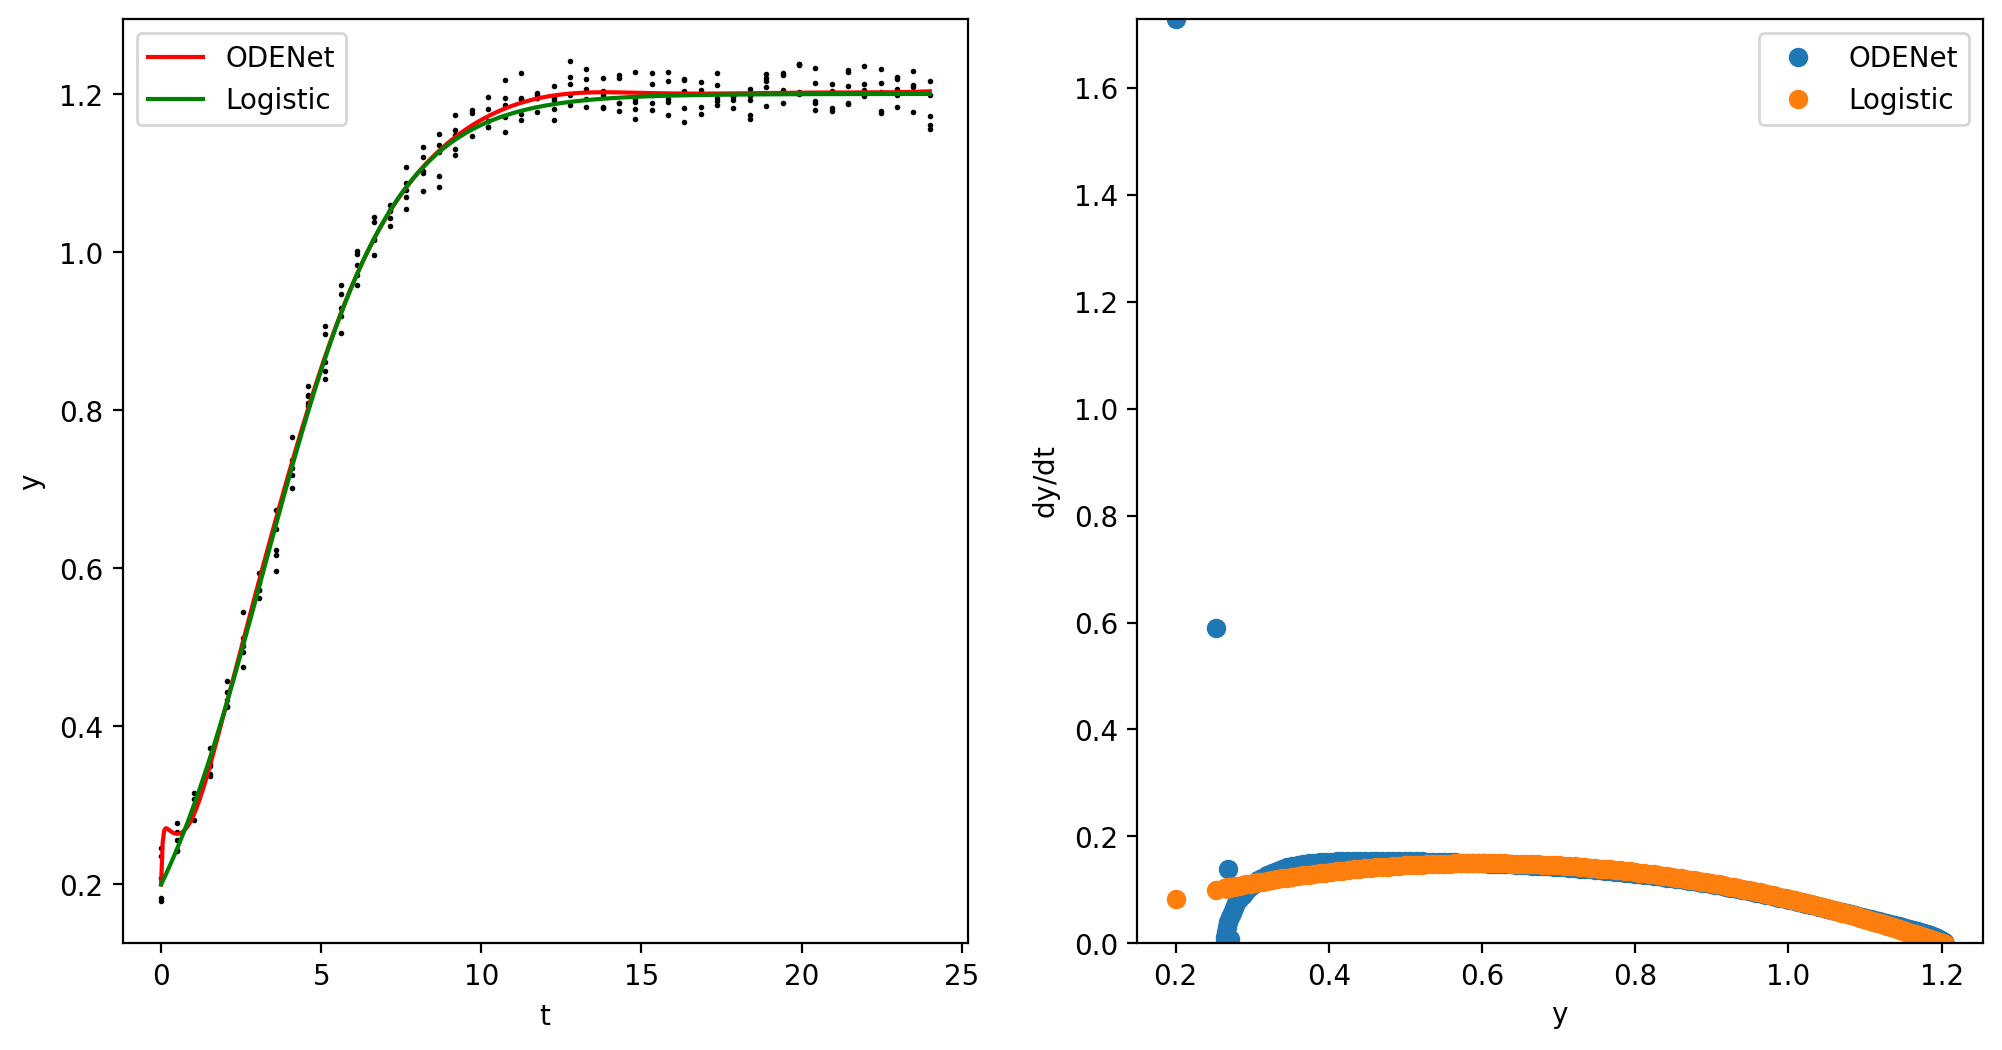

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tt = jnp.linspace(t[0,0], t[0,-1], 500)

ax = axes[0]
ax.plot(t, y, '.k', markersize=2)
yhat = odenet_odeint(tt, odenet_params).squeeze()
ax.plot(tt, yhat, '-r', label='ODENet');\
ax.plot(tt, logistic(tt, y0, r, K), '-g', label='Logistic');
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
ax.legend()

ax = axes[1]
dyhatdt = [mlp_ode(yhat[i], tt[i], odenet_params) for i in range(len(tt))]
dydt = [logistic_ode(yhat[i], tt[i], r, K)  for i in range(len(tt))]

ax.plot(yhat, dyhatdt, 'o', label='ODENet')
ax.plot(yhat, dydt, 'o', label='Logistic')
ax.set_ylim(0, max(dyhatdt))
ax.set_xlabel('$y$')
ax.set_ylabel('$dy/dt$')
ax.legend();